In [1]:
from corenlp_xml_reader import AnnotatedText as A
from lxml import html
from collections import defaultdict
# import networkx as nx
# import nxpd
from wordcloud import WordCloud
from utils.file_io_helper import unicode_normalizer,read_books_json
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import glob
import os 
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)


In [2]:
def sentence_out(sent):
    return ' '.join([w['word'] for w in sent['tokens']])


def co_occurence(doc,sentiment):
    pair_sent = defaultdict(list)
    for sentence in doc.sentences:

        curr_name = []
        prev_ner = None
        for ent in sentence['tokens']:
            if ent['ner'] == 'PERSON':
                name = ent['word']
                size = len(name)
                if not prev_ner or prev_ner == name:
                    prev_ner = name
                else:
                    prev_ner += ' ' + name
            else:
                if prev_ner:
                    curr_name.append(prev_ner)
                prev_ner = None
        if prev_ner:
            curr_name.append(prev_ner)
            
        pair = []
        if curr_name:
            prev = None
            for name_ in curr_name:
                if (not prev or prev!=name_) and len(pair)<2:
                    pair.append(name_)
                    prev = name_
            pair = tuple(sorted(pair))
            
        if len(pair)==2:
            pair_sent[pair].append((sentence_out(sentence),sentiment[sentence['id']]))
    return pair_sent

def xml_analysis(xml_file,limit = 1):
    translate = {'Verynegative':-2, 'Negative':-1,'Positive':1,'Verypositive':2,'Neutral':0}
    xml = open(xml_file).read()
    annotated_text = A(xml)
    
    tree = html.fromstring(xml)
    sentiment = tree.xpath('//sentence/@sentiment')
    sentiment = [translate[key] for key in sentiment]

    pair_dict =co_occurence(annotated_text,sentiment)
    
    avg_sent = lambda x:np.mean([y[1] for y in x])
    return pair_dict

def combine_xml(path):
    related_sentence_dict = {}
    for f in glob.glob('{}/*.xml'.format(path)):
        related_sentence_dict[str(os.path.basename(f).split('.')[0])]=xml_analysis(f)
    return related_sentence_dict
        
    

In [3]:
related_sentences = combine_xml('../data/summary-tag')


In [262]:
import pickle
pickle.dump( related_sentences, open( "../data/related_sentences.p", "wb" ) )

In [273]:
a  = xml_analysis("../data/summary-tag/100.Cat's_Cradle.txt.html.txt.xml")
# labels = read_books_json('../data/all_label2.json')
labels =  pickle.load( open( "../data/all_label.p", "rb" ) )
summaries = read_books_json('../data/book_summary3.json')

In [274]:
labels['266']

{('Bea Sorenson', 'Miles Bjornstam'): u'Wife/Husband',
 ('Carol', 'Aunt Bessie and Uncle Whittier Smail'): u'Dislike',
 ('Carol', 'Bea Sorenson'): u'Friends',
 ('Carol', 'Erik Valborg'): u'Romantic friendship',
 ('Carol', 'Fern Mullins'): u'Friends',
 ('Carol', 'Guy Pollock'): u'Friends',
 ('Carol', 'Hugh'): u'Mother/Son',
 ('Carol', 'Kennicott'): u'Wife/Husband',
 ('Carol', 'Miles Bjornstam'): u'Acquaintances',
 ('Carol', 'Mrs. Bogart'): u'Neighbors',
 ('Carol', 'Percy Bresnahan'): u'Acquaintances',
 ('Carol', 'Vida Sherwin'): u'Friends',
 ('Kennicott', 'Hugh'): u'Father/Son',
 ('Kennicott', 'Maud Dyer'): u'Secret affair',
 ('Vida Sherwin', 'Aunt Bessie and Uncle Whittier Smail'): u'Relatives',
 ('Vida Sherwin', 'Raymond Wutherspoon'): u'Wife/Husband'}

In [68]:
raw_labels = [ b.values() for b in labels.values()]

In [69]:
raw_labels = [i.lower().strip() for j in raw_labels for i in j]

(-0.5, 399.5, 199.5, -0.5)

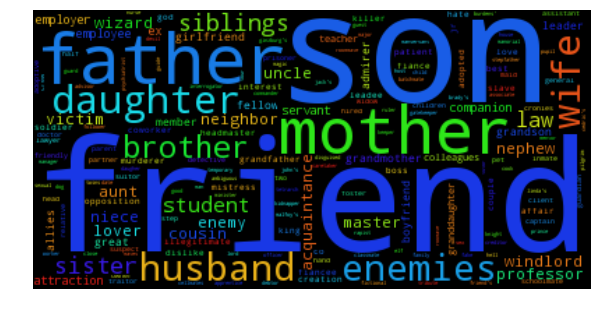

In [70]:
# Read the whole text.
# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(raw_labels))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [227]:
label_array = np.array(raw_labels)
family = ['father','mother','aunt','wife','daughter','sibling','twin','family','heir','ancestor',
          'brother','uncle','sister','niece','grand','cousin','adopt','relat','nephew','son','child','divorce']
friend = ['friend','playmate','widow','frien']
romance = ['ex','lover','love','girlfriend','attraction','boyfriend','affair','engage',
          'fiance','crush','date','sweet','partner','couple','flirt','marr']
enemy = ['enem','victim','traitor','compet','parties','riv','dislike','foe','death','counter',
         'murder','accuse','duel','conflicts','hate','foil','opposition','disguise','kill']
acquaintance = ['acqua','coworker','student','prof','pup','roommate','school','work','host','housemates','companion',
               'neighbor','roomate','wizard','ally','allies','flatmate','mate','group','miss','member','peasant',
               'coll','train','comrade','land']
service = ['fellow','assist','doctor','detect','devil','master','mistress','slave','rule','henchman',
           'employer','serv','lead','law','king','prison',',coach','proph','resear','edit','ward',
           'cook','sale','officer','boss','office','lord','emperor','interview','chief','support','advis',
          'nurse','man','owner','mentor','benef','manager','ruler','starbuck','super','tetrarch','tour',
          'counsel','judge','merchant','employ','flower','general','warder','house','soldier','maid','major','help',
           'patient','cook','ward','business','bank','tenant','keeper','captain','tutor','keeper','actor','buy','lend',
          'porter','caller','scout','hire','protect','guide','attorney','coach','caretaker','associate','advers',
          'interrogator','harpooner','henchman']
label_dict = OrderedDict([('enemy',enemy),('romance',romance),('family',family),('friend',friend),
                         ('acquaintance',acquaintance),('service',service)])


In [231]:
def clean_label(label):
    for key,value in label_dict.iteritems():
        for v in value:
            if re.search(v,label):
                return key
    return 'ambiguous'
fv = np.vectorize(clean_label)


In [232]:
# group_label = label_array. clean_label('father')
#len(set(fv(label_array)))


In [233]:
set(fv(label_array))

{'acquaintance',
 'ambiguous',
 'enemy',
 'family',
 'friend',
 'romance',
 'service'}

In [263]:
cleaned_label = fv(label_array)
# pickle.dump( related_sentences, open( "../data/related_sentences.p", "wb" ) )

NameError: name 'clean_label' is not defined